In [17]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

import matplotlib.pyplot as plot
import numpy as np
from numpy import genfromtxt
import csv
import sys, os, re
import pathlib

print(tf.__version__)

2.0.0


In [18]:
# The CANlab/WAVi Pain Study is Pre-Formatted to resemble BIDS neuroimaging formatting
# If your study does not abide to the following structure, please revisit previous scripts
# .../StudyRepo
# -------------> /raw
# -------------------> /*.art
# -------------------> /*.eeg
# -------------------> /*.evt
# -------------> /contigs

In [19]:
if "contigs" not in os.getcwd():
    try:
        os.chdir("CANlabStudy/contigs")
        directory=os.getcwd()
    except:
        print("I couldn't find the contigs folder.\n")
        directory = input("Please give the full path of the contigs folder: ")
        os.chdir(directory)

In [20]:
train_path = pathlib.Path('p300/')
#train_path = pathlib.Path('chronic/')
#train_path = pathlib.Path('/')

In [21]:
# load in image paths for training set

import random

train_image_paths = os.listdir(train_path)
#train_image_paths = list(train_path.glob('*/*'))
train_image_paths = [str(path) for path in train_image_paths]
random.shuffle(train_image_paths)

train_count = len(train_image_paths)
print("You have", train_count, "training images.")

You have 1513 training images.


In [22]:
#list the available labels
label_names = ['ctrl', 'pain']
#label_names = sorted(item.name for item in train_path.glob('*/') if item.is_dir())
print("Labels discovered:", label_names)

Labels discovered: ['ctrl', 'pain']


In [23]:
#assign an index to each label
label_to_index = dict((name, index) for index, name in enumerate(label_names))
print("Label indices:", label_to_index)

Label indices: {'ctrl': 0, 'pain': 1}


In [24]:
#create a list of every file and its index label

train_image_labels = [label_to_index[path[:4]] for path in train_image_paths]
#train_image_labels = [label_to_index[pathlib.Path(path).parent.name]
 #                   for path in train_image_paths]
# force list of strings to numpy array
train_image_labels = np.array(train_image_labels)

In [25]:
def normalize(array):
    nom = (array - array.min())*(1 - 0)
    denom = array.max() - array.min()
    denom+=(10**-10)
    return 0 + nom/denom

In [26]:
def load_numpy_stack(lead, paths):
    numpy_stack = []
    for path in paths:
        path = lead+path
        array = genfromtxt(path, delimiter=",")
        array = normalize(array)
        array = array.reshape(array.shape +(1,))
        numpy_stack.append(array)
    numpy_dataset = np.rollaxis(np.block(numpy_stack), 2, 0)
    numpy_dataset = numpy_dataset.reshape(numpy_dataset.shape+(1,))
    return(numpy_dataset)

In [28]:
train_arrays = load_numpy_stack('p300/', train_image_paths)
#train_arrays = load_numpy_stack('', train_image_paths)

In [29]:
def createModel(learn, num_epochs, betaOne, betaTwo):
    # Introduce sequential Set
    model = tf.keras.models.Sequential()
    
    # Create a convolutional base
    model.add(tf.keras.layers.Conv2D(5, kernel_size=6, strides=6, padding='same', activation='relu', data_format='channels_last', use_bias=False))    
    model.add(tf.keras.layers.Conv2D(5, kernel_size=6, strides=6, padding='same', activation='relu', data_format='channels_last', use_bias=False))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=None, padding='same', data_format=None))
    model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.Conv2D(5, kernel_size=6, strides=6, padding='same', activation='relu', data_format='channels_last', use_bias=False))
    model.add(tf.keras.layers.Conv2D(5, kernel_size=6, strides=6, padding='same', activation='relu', data_format='channels_last', use_bias=False))
    #model.add(tf.keras.layers.Conv2D(5, kernel_size=5, strides=5, padding='same', activation='relu', data_format='channels_last', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
    
    # Layers
    #model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=None, padding='same', data_format=None))
    model.add(tf.keras.layers.Flatten(data_format="channels_last"))   
    
    # Hidden layers
    model.add(tf.keras.layers.Dense(2, activation='softmax'))
    
    model.build(train_arrays.shape)
    model.summary()
    
    # Model compilation
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learn, beta_1=betaOne, beta_2=betaTwo),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    
    history = model.fit(train_arrays, train_image_labels, epochs=num_epochs,
                       validation_split=0.33)
    
    return(history)

What's my learning rate? 0.001
What's my beta1? 0.99
What's my beta2? 0.999
How many epochs? 500
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           multiple                  180       
_________________________________________________________________
conv2d_13 (Conv2D)           multiple                  900       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 multiple                  0         
_________________________________________________________________
dropout_3 (Dropout)          multiple                  0         
_________________________________________________________________
conv2d_14 (Conv2D)           multiple                  900       
_________________________________________________________________
conv2d_15 (Conv2D)           multiple                  900       
_______________________

1013/1013 [==============================] - 1s 897us/sample - loss: 0.3847 - accuracy: 0.8085 - val_loss: 0.4476 - val_accuracy: 0.7920
Epoch 44/500
1013/1013 [==============================] - 1s 924us/sample - loss: 0.3777 - accuracy: 0.8282 - val_loss: 0.4444 - val_accuracy: 0.7900
Epoch 45/500
1013/1013 [==============================] - 1s 880us/sample - loss: 0.3571 - accuracy: 0.8282 - val_loss: 0.4410 - val_accuracy: 0.8000
Epoch 46/500
1013/1013 [==============================] - 1s 937us/sample - loss: 0.3589 - accuracy: 0.8292 - val_loss: 0.4185 - val_accuracy: 0.8200
Epoch 47/500
1013/1013 [==============================] - 1s 875us/sample - loss: 0.3868 - accuracy: 0.8184 - val_loss: 0.4491 - val_accuracy: 0.7960
Epoch 48/500
1013/1013 [==============================] - 1s 964us/sample - loss: 0.3516 - accuracy: 0.8401 - val_loss: 0.4307 - val_accuracy: 0.8200
Epoch 49/500
1013/1013 [==============================] - 1s 921us/sample - loss: 0.3693 - accuracy: 0.8272 - val

Epoch 98/500
1013/1013 [==============================] - 1s 979us/sample - loss: 0.2630 - accuracy: 0.8924 - val_loss: 0.4338 - val_accuracy: 0.8100
Epoch 99/500
1013/1013 [==============================] - 1s 859us/sample - loss: 0.2734 - accuracy: 0.8746 - val_loss: 0.4652 - val_accuracy: 0.8000
Epoch 100/500
1013/1013 [==============================] - 1s 885us/sample - loss: 0.3032 - accuracy: 0.8677 - val_loss: 0.4408 - val_accuracy: 0.8020
Epoch 101/500
1013/1013 [==============================] - 1s 932us/sample - loss: 0.2909 - accuracy: 0.8746 - val_loss: 0.4488 - val_accuracy: 0.8040
Epoch 102/500
1013/1013 [==============================] - 1s 939us/sample - loss: 0.2963 - accuracy: 0.8667 - val_loss: 0.4581 - val_accuracy: 0.7900
Epoch 103/500
1013/1013 [==============================] - 1s 892us/sample - loss: 0.2709 - accuracy: 0.8717 - val_loss: 0.4328 - val_accuracy: 0.8120
Epoch 104/500
1013/1013 [==============================] - 1s 870us/sample - loss: 0.2756 - accu

1013/1013 [==============================] - 1s 952us/sample - loss: 0.2353 - accuracy: 0.9161 - val_loss: 0.4668 - val_accuracy: 0.8000
Epoch 153/500
1013/1013 [==============================] - 1s 1ms/sample - loss: 0.2392 - accuracy: 0.8993 - val_loss: 0.4196 - val_accuracy: 0.8200
Epoch 154/500
1013/1013 [==============================] - 1s 921us/sample - loss: 0.2397 - accuracy: 0.8944 - val_loss: 0.4590 - val_accuracy: 0.8120
Epoch 155/500
1013/1013 [==============================] - 1s 904us/sample - loss: 0.2172 - accuracy: 0.9042 - val_loss: 0.4245 - val_accuracy: 0.8140
Epoch 156/500
1013/1013 [==============================] - 1s 918us/sample - loss: 0.2112 - accuracy: 0.9112 - val_loss: 0.4595 - val_accuracy: 0.8200
Epoch 157/500
1013/1013 [==============================] - 1s 928us/sample - loss: 0.2139 - accuracy: 0.9082 - val_loss: 0.4334 - val_accuracy: 0.8260
Epoch 158/500
1013/1013 [==============================] - 1s 933us/sample - loss: 0.2497 - accuracy: 0.8924 -

1013/1013 [==============================] - 1s 876us/sample - loss: 0.2094 - accuracy: 0.9171 - val_loss: 0.4086 - val_accuracy: 0.8420
Epoch 207/500
1013/1013 [==============================] - 1s 869us/sample - loss: 0.2101 - accuracy: 0.9131 - val_loss: 0.4137 - val_accuracy: 0.8340
Epoch 208/500
1013/1013 [==============================] - 1s 869us/sample - loss: 0.2290 - accuracy: 0.9092 - val_loss: 0.4085 - val_accuracy: 0.8180
Epoch 209/500
1013/1013 [==============================] - 1s 861us/sample - loss: 0.2272 - accuracy: 0.9072 - val_loss: 0.4520 - val_accuracy: 0.8180
Epoch 210/500
1013/1013 [==============================] - 1s 933us/sample - loss: 0.2022 - accuracy: 0.9151 - val_loss: 0.4322 - val_accuracy: 0.8380
Epoch 211/500
1013/1013 [==============================] - 1s 852us/sample - loss: 0.2171 - accuracy: 0.9191 - val_loss: 0.4305 - val_accuracy: 0.8320
Epoch 212/500
1013/1013 [==============================] - 1s 926us/sample - loss: 0.2534 - accuracy: 0.8944

1013/1013 [==============================] - 1s 959us/sample - loss: 0.1918 - accuracy: 0.9230 - val_loss: 0.4653 - val_accuracy: 0.8240
Epoch 261/500
1013/1013 [==============================] - 1s 1ms/sample - loss: 0.1823 - accuracy: 0.9289 - val_loss: 0.4567 - val_accuracy: 0.8200
Epoch 262/500
1013/1013 [==============================] - 1s 917us/sample - loss: 0.2015 - accuracy: 0.9191 - val_loss: 0.4531 - val_accuracy: 0.8320
Epoch 263/500
1013/1013 [==============================] - 1s 922us/sample - loss: 0.2066 - accuracy: 0.9220 - val_loss: 0.4531 - val_accuracy: 0.8220
Epoch 264/500
1013/1013 [==============================] - 1s 846us/sample - loss: 0.1982 - accuracy: 0.9210 - val_loss: 0.4668 - val_accuracy: 0.8100
Epoch 265/500
1013/1013 [==============================] - 1s 903us/sample - loss: 0.1793 - accuracy: 0.9289 - val_loss: 0.4183 - val_accuracy: 0.8400
Epoch 266/500
1013/1013 [==============================] - 1s 823us/sample - loss: 0.1940 - accuracy: 0.9151 -

1013/1013 [==============================] - 1s 911us/sample - loss: 0.2135 - accuracy: 0.9062 - val_loss: 0.4406 - val_accuracy: 0.8300
Epoch 315/500
1013/1013 [==============================] - 1s 855us/sample - loss: 0.2021 - accuracy: 0.9161 - val_loss: 0.4997 - val_accuracy: 0.8240
Epoch 316/500
1013/1013 [==============================] - 1s 914us/sample - loss: 0.1907 - accuracy: 0.9260 - val_loss: 0.4792 - val_accuracy: 0.8160
Epoch 317/500
1013/1013 [==============================] - 1s 885us/sample - loss: 0.1931 - accuracy: 0.9250 - val_loss: 0.4059 - val_accuracy: 0.8280
Epoch 318/500
1013/1013 [==============================] - 1s 906us/sample - loss: 0.1824 - accuracy: 0.9279 - val_loss: 0.4556 - val_accuracy: 0.8120
Epoch 319/500
1013/1013 [==============================] - 1s 898us/sample - loss: 0.2255 - accuracy: 0.9121 - val_loss: 0.4168 - val_accuracy: 0.8340
Epoch 320/500
1013/1013 [==============================] - 1s 851us/sample - loss: 0.2042 - accuracy: 0.9151

1013/1013 [==============================] - 1s 841us/sample - loss: 0.1760 - accuracy: 0.9319 - val_loss: 0.4922 - val_accuracy: 0.8180
Epoch 369/500
1013/1013 [==============================] - 1s 883us/sample - loss: 0.1850 - accuracy: 0.9230 - val_loss: 0.4072 - val_accuracy: 0.8340
Epoch 370/500
1013/1013 [==============================] - 1s 837us/sample - loss: 0.1874 - accuracy: 0.9220 - val_loss: 0.6566 - val_accuracy: 0.7780
Epoch 371/500
1013/1013 [==============================] - 1s 877us/sample - loss: 0.1767 - accuracy: 0.9191 - val_loss: 0.4536 - val_accuracy: 0.8140
Epoch 372/500
1013/1013 [==============================] - 1s 923us/sample - loss: 0.1849 - accuracy: 0.9260 - val_loss: 0.5114 - val_accuracy: 0.8160
Epoch 373/500
1013/1013 [==============================] - 1s 914us/sample - loss: 0.1999 - accuracy: 0.9240 - val_loss: 0.4554 - val_accuracy: 0.8240
Epoch 374/500
1013/1013 [==============================] - 1s 1ms/sample - loss: 0.1608 - accuracy: 0.9309 -

1013/1013 [==============================] - 1s 906us/sample - loss: 0.1831 - accuracy: 0.9299 - val_loss: 0.5648 - val_accuracy: 0.8080
Epoch 423/500
1013/1013 [==============================] - 1s 883us/sample - loss: 0.1874 - accuracy: 0.9191 - val_loss: 0.4571 - val_accuracy: 0.8160
Epoch 424/500
1013/1013 [==============================] - 1s 881us/sample - loss: 0.1701 - accuracy: 0.9250 - val_loss: 0.4707 - val_accuracy: 0.8120
Epoch 425/500
1013/1013 [==============================] - 1s 943us/sample - loss: 0.1680 - accuracy: 0.9348 - val_loss: 0.4954 - val_accuracy: 0.8260
Epoch 426/500
1013/1013 [==============================] - 1s 996us/sample - loss: 0.1515 - accuracy: 0.9388 - val_loss: 0.4497 - val_accuracy: 0.8320
Epoch 427/500
1013/1013 [==============================] - 1s 869us/sample - loss: 0.1463 - accuracy: 0.9447 - val_loss: 0.5163 - val_accuracy: 0.8200
Epoch 428/500
1013/1013 [==============================] - 1s 925us/sample - loss: 0.1460 - accuracy: 0.9487

1013/1013 [==============================] - 1s 906us/sample - loss: 0.1561 - accuracy: 0.9388 - val_loss: 0.4816 - val_accuracy: 0.8320
Epoch 477/500
1013/1013 [==============================] - 1s 880us/sample - loss: 0.1432 - accuracy: 0.9497 - val_loss: 0.4923 - val_accuracy: 0.8160
Epoch 478/500
1013/1013 [==============================] - 1s 896us/sample - loss: 0.1412 - accuracy: 0.9526 - val_loss: 0.4799 - val_accuracy: 0.8240
Epoch 479/500
1013/1013 [==============================] - 1s 880us/sample - loss: 0.1526 - accuracy: 0.9348 - val_loss: 0.4835 - val_accuracy: 0.8340
Epoch 480/500
1013/1013 [==============================] - 1s 895us/sample - loss: 0.1345 - accuracy: 0.9388 - val_loss: 0.5010 - val_accuracy: 0.8240
Epoch 481/500
1013/1013 [==============================] - 1s 866us/sample - loss: 0.1725 - accuracy: 0.9329 - val_loss: 0.4721 - val_accuracy: 0.8260
Epoch 482/500
1013/1013 [==============================] - 1s 894us/sample - loss: 0.1720 - accuracy: 0.9289

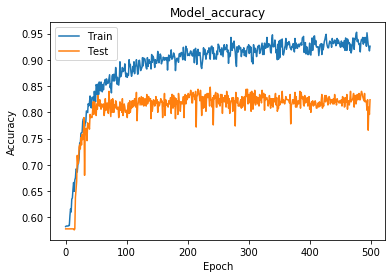

In [31]:
rates = np.arange(0.01, 0.1, 0.01)
beta1s = np.arange(0.9, 0.99, 0.01)
beta2s = np.arange(0.99, 0.999, 0.001)

rate = float(input("What's my learning rate? "))
beta1 = float(input("What's my beta1? "))
beta2 = float(input("What's my beta2? "))
epochs = int(input("How many epochs? "))

# compiled = kerasModel(rate)
# fitted = fitModel(compiled, epochs)
fitted = createModel(rate, epochs, beta1, beta2)

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(fitted.history['accuracy'])
plt.plot(fitted.history['val_accuracy'])
plt.title('Model_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#results = testModel(fitted)
#myresults.append(results)

In [117]:
myresults

# print("Loss: ", results[0], "\nAccuracy: ", results[1])

[[0.22637348339475435, 0.9122222], [0.3669460266828537, 0.8705556]]